#Multi-object Instance Segmentaion

Detectron2 is a platform built by the Facebook team.

Detectron2 includes high-quality implementations of state-of-the-art-object (SOTA) detection algorithms, including DensePose of the Mask R-CNN model family. The original Detectron framework was written in Caffe2, while the Detectron2 framework is written using PyTorch.

Detectron2 supports a range of tasks related to object detection. Like the original Detectron, it supports object detection with boxes and instance segmentation masks, as well as human pose prediction. Beyond that, Detectron2 adds support for semantic segmentation and panoptic segmentation (a task that combines both semantic and instance segmentation). By leveraging Detectron2, we are able to build object detection, segmentation, and pose estimation in a few lines of code.


##Fetching and preparing data
We will be working on the images that are available in the Open Images dataset (which contains millions of images along with their annotations provided by Google at `https://storage.googleapis.com/openimages/web/index.html`.

In this part of code, we will learn about fetching only the required images and not the entire dataset. Note that this step is required, as the dataset size prohibits a typical user who might not have extensive resources from building a model:

##1.Install the required packages


In [1]:
pip install -qU openimages torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 58.3 MB/s eta 0:00:00
   ━━━━━

##2.Download the required annotations files

In [2]:
from torch_snippets import *
!wget -O train-annotations-object-segmentation.csv -q https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv
!wget -O classes.csv -q https://raw.githubusercontent.com/openimages/dataset/master/dict.csv

##3.Specify the classes that we want our model to predict (you can visit the Open Images website to see the list of all classes):

In [3]:
required_classes = 'person,dog,bird,car,elephant, football, jug,laptop,mushroom,pizza,rocket,shirt,traffic sign,watermelon,zebra'
required_classes = [c.lower() for c in required_classes.lower().split(',')]

classes = pd.read_csv('classes.csv', header=None)
classes.columns = ['class', 'class_name']
classes = classes[classes['class_name'].map(lambda x: x in required_classes)]

##4.Fetch the image IDs and masks corresponding to `required_classes`:

In [4]:
df = pd.read_csv('train-annotations-object-segmentation.csv')
df.head()

data = pd.merge(df, classes, left_on='LabelName', right_on='class')

subset_data = data.groupby('class_name').agg({'ImageID': lambda x: list(x)[:500]})
subset_data = flatten(subset_data.ImageID.tolist())
subset_data = data[data['ImageID'].map(lambda x: x in subset_data)]
subset_masks = subset_data['MaskPath'].to_list()

Given the vast amount of data, we are only fetching 500 images per class in `subset_data`. It is up to you whether you fetch a smaller or larger set of the files per class and the list of unique classes (`required_classes`).

So far, we only have the `ImageId` and `MaskPath` values corresponding to an image. In the next steps, we will go ahead and download the actual images and masks form  `open-images`.

##5.Unziping the files

Now that we have subset of masks data to download, let's start the download. Open Images has 16 ZIP files for training masks. Each ZIP file will have only a few masks from `subset_masks`, so we will delete the rest after moving the required masks into a seperate folder. This download -> move -> delete action will keep memory footprint relatively small. We will have to run this step once for each of the 16 files:


In [5]:
!mkdir -p masks
for c in Tqdm('0123456789abcdef'):
  !wget -q https://storage.googleapis.com/openimages/v5/train-masks/train-masks-{c}.zip
  !unzip -q train-masks-{c}.zip -d tmp_masks
  !rm train-masks-{c}.zip
  tmp_masks = Glob('tmp_masks', silent=True)
  items = [(m,fname(m)) for m in tmp_masks]
  items = [(i,j) for (i,j) in items if j in subset_masks]
  for i,j in items:
    os.rename(i, f'masks/{j}')

  !rm -rf tmp_masks

  0%|          | 0/16 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [6]:
import os
import requests
from tqdm import tqdm
from glob import glob  # Using glob instead of Glob()

# Create the masks directory
os.makedirs("masks", exist_ok=True)

# Define the URL template
url_template = "https://storage.googleapis.com/openimages/v5/train-masks/train-masks-{}.zip"

# Iterate over all hexadecimal characters
for c in tqdm("0123456789abcdef", desc="Downloading masks"):
    url = url_template.format(c)
    zip_path = f"train-masks-{c}.zip"

    # Download the file using requests
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded: {zip_path}")
    else:
        print(f"Failed: {url} (Status: {response.status_code})")
        continue  # Skip to the next file

    # Unzip the downloaded file
    os.system(f"unzip -q {zip_path} -d tmp_masks")
    os.remove(zip_path)  # Remove the ZIP file after extraction

    # Get the extracted files
    tmp_masks = glob("tmp_masks/*")  # Using glob() to find files

    # Process the files
    items = [(m, os.path.basename(m)) for m in tmp_masks]
    items = [(i, j) for (i, j) in items if j in subset_masks]

    for i, j in items:
        os.rename(i, f"masks/{j}")

    # Clean up the temporary directory
    os.system("rm -rf tmp_masks")


Downloaded: train-masks-0.zip


Downloaded: train-masks-1.zip


Downloaded: train-masks-2.zip


Downloaded: train-masks-3.zip


Downloaded: train-masks-4.zip


Downloaded: train-masks-5.zip


Downloaded: train-masks-6.zip


Downloaded: train-masks-7.zip


Downloaded: train-masks-8.zip


Downloaded: train-masks-9.zip


Downloaded: train-masks-a.zip


Downloaded: train-masks-b.zip


Downloaded: train-masks-c.zip


Downloaded: train-masks-d.zip


Downloaded: train-masks-e.zip


Downloaded: train-masks-f.zip


##6.Download the images corresponding to `ImageId`:

In [7]:
masks = Glob('masks')
masks = [fname(mask) for mask in masks]

subset_data = subset_data[subset_data['MaskPath'].map(lambda x: x in masks)]
subset_imageIds = subset_data['ImageID'].tolist()

from openimages.download import _download_images_by_id
!mkdir images
_download_images_by_id(subset_imageIds, 'train', './images/')

100%|██████████| 12842/12842 [12:52<00:00, 16.62it/s]


##7.Zip all the images, masks, and ground truths and save them

Just incase your session crashes, it is helpful to save and retrieve the file for later training. Once the ZIP file is created, ensure you save the file in your drive or download it. The file size ends up being around 2.5 GB

In [8]:
import zipfile
files = Glob('images') + Glob('masks') + ['train-annotations-object-segmentation.csv', 'classes.csv']
with zipfile.ZipFile('data.zip', 'w') as zipme:
  for file in Tqdm(files):
    zipme.write(file, compress_type=zipfile.ZIP_DEFLATED)

100%|██████████| 17938/17938 [02:30<00:00, 118.92it/s]


Finally, move the data into a single directory:


In [9]:
!ls


classes.csv  data.zip  images  masks  sample_data  train-annotations-object-segmentation.csv


In [10]:
!find . -type d -name "images"


./images


In [11]:
!ls -l tmp_masks


ls: cannot access 'tmp_masks': No such file or directory


In [12]:
!mkdir -p train/
!mv images train/myData2020
!mv masks train/annotations

In [13]:
!ls -l train/

total 1096
drwxr-xr-x 2 root root 884736 Feb  8 09:06 annotations
drwxr-xr-x 2 root root 229376 Feb  8 09:19 myData2020


Given that there are so many moving components in object detection code, as a standardization method, Detectron accepts a rigid data format for training.

While it is possible to write a dataset definition and feed it to Detectron, it is easier (and more profitable) to save the entire training data in COCO format. This way, you can leverage other training algorithms, such as  **detectron transformer (DETR)**, with no change to the data.

##8.First, we will start by defining the categories of classes:

###i.Define the required categories in COCO format:

In [14]:
%cd /content/
!git clone https://github.com/sizhky/pycococreator.git
%cd pycococreator
%pip install -e .
%cd -
%pip install pycocotools

/content
Cloning into 'pycococreator'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 176 (delta 3), reused 2 (delta 0), pack-reused 165 (from 1)
Receiving objects: 100% (176/176), 184.22 KiB | 14.17 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/pycococreator
Obtaining file:///content/pycococreator
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pycococreatortools
/content


In [15]:
import datetime

INFO = {
  "description": "MyData2020",
  "url": "None",
  "version":"1.0",
  "year":2020,
  "contributor":"sizhky",
  "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
  {
      "id": 1,
      "name": "MIT",
  }
]

CATEGORIES = [{'id':id+1, 'name': name.replace('/', ''), 'supercategory':'none'} for id,(_,(name, clss_name)) in enumerate(classes.iterrows())]


In the preceding code, in the definition of `CATEGORIES`, we are creating a new key called `supercategory`. To understand `supercategory`, let's go through an example: the `Man` and `Woman` classes are categories belonging to the `Person` supercategories, we will specify it as `none`.

###ii.Import the relevant packages and create an empty dictionary with the keys needed to save the COCO JSON file.

In [16]:
from pycococreator.pycococreatortools import pycococreatortools
from os import listdir
from os.path import isfile, join
from PIL import Image

coco_output = {
  "info": INFO,
  "licenses": LICENSES,
  "categories": CATEGORIES,
  "images": [],
  "annotations": []
}

###iii.Set a few variables in place that contain the infromation on the image locations and annotation file locations:

In [17]:
ROOT_DIR = "train"
IMAGE_DIR, ANNOTATION_DIR = 'train/myData2020/', 'train/annotations/'
image_files = [f for f in listdir(IMAGE_DIR) if isfile(join(IMAGE_DIR, f))]
annotation_files = [f for f in listdir(ANNOTATION_DIR) if isfile(join(ANNOTATION_DIR, f))]

###iv.Loop through each image filename and populate the `images` key in the `coco_output` dictionary:

In [18]:
image_id = 1
# go through each image
for image_filename in Tqdm(image_files):
  image = Image.open(IMAGE_DIR + '/' + image_filename)
  image_info = pycococreatortools.create_image_info(image_id, os.path.basename(image_filename), image.size)
  coco_output["images"].append(image_info)
  image_id = image_id + 1

100%|██████████| 5094/5094 [00:00<00:00, 10775.33it/s]


##9.Loop through each segmentation annotation and populate the `annotations` key in the `coco_output` dictionary:



In [19]:
segmentation_id = 1
for annotation_filename in Tqdm(annotation_files):
  image_id = [f for f in coco_output['images'] if stem(f['file_name']) == annotation_filename.split('_')[0]][0]['id']
  class_id = [x['id'] for x in CATEGORIES if x['name'] in annotation_filename][0]
  category_info = {'id':class_id, 'is_crowd':'crowd' in image_filename}
  binary_mask = np.asarray(Image.open(f'{ANNOTATION_DIR}/{annotation_filename}').convert('1')).astype(np.uint8)

  annotation_info = pycococreatortools.create_annotation_info(segmentation_id, image_id, category_info, binary_mask, image.size, tolerance=2)

  if annotation_info is not None:
    coco_output["annotations"].append(annotation_info)
    segmentation_id = segmentation_id+1


100%|██████████| 12842/12842 [14:20<00:00, 14.93it/s]


##10.Save `coco_output` in a JSON file:

In [20]:
coco_output['categories'] = [{'id':id+1, 'name': clss_name, 'supercategory': 'none'} for id,(_, (name, clss_name)) in enumerate(classes.iterrows())]

import json
with open('images.json', 'w') as output_json_file:
  json.dump(coco_output, output_json_file)

# Training the model for instance segmentation

To train our model, we need to download the required packages, modify the configuration file to reflect the dataset paths, and then train the model.

Let's go through the steps:

##1.Install teh required Detectron2 packages

In [21]:
%cd /content/
# install detectron2

!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
%pip install -r requirements.txt
!python setup.py install
%cd /content
!git clone https://github.com/facebookresearch/fvcore.git
%cd /content/fvcore
%pip install -e .

/content
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
/content/detectron2
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        *******************************

Restart the notebook if below cell fails to execute,

and start running from above cell

no need to run from the very top

##2.Import teh relevant `detectron2` packages:

In [22]:
!pip install antlr4-python3-runtime


DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/detectron2-0.6-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/hydra_core-1.4.0.dev1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/omegaconf-2.3.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/mypy_extensions-1.0.0-py3.11.egg is deprecated. pip 24.3

In [23]:
!pip install --upgrade antlr4-python3-runtime


DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/detectron2-0.6-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/hydra_core-1.4.0.dev1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/omegaconf-2.3.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/mypy_extensions-1.0.0-py3.11.egg is deprecated. pip 24.3

In [24]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html


DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/detectron2-0.6-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/hydra_core-1.4.0.dev1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/omegaconf-2.3.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/mypy_extensions-1.0.0-py3.11.egg is deprecated. pip 24.3

In [7]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer

##3.Register the created datasets using `register_coco_instances`:

In [21]:
!cd train && ls

annotations  myData2020


In [22]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "images.json", "train/myData202")

In [3]:
%pip install torch_snippets

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/detectron2-0.6-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/omegaconf-2.3.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/mypy_extensions-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/black-25.1.0-py3.11-linux-x86_64.egg is deprecated. pip 

In [4]:
!ls

classes.csv  detectron2  images.json	sample_data  train-annotations-object-segmentation.csv
data.zip     fvcore	 pycococreator	train


In [9]:
!cd train/ && ls

annotations  myData2020


Given that we have restarted Colab, let's re-fetch the required classes:

In [5]:
from torch_snippets import *
required_classes='person,dog,bird,car,elephant,football,jug,laptop,Mushroom,Pizza,Rocket,Shirt,Traffic sign,Watermelon,Zebra'
required_classes = [c.lower() for c in required_classes.lower().split(',')]
classes = pd.read_csv('classes.csv', header=None)
classes.columns =['class','class_name']
classes =classes[classes['class_name'].map(lambda x: x in required_classes)]

##4.Define all the parameters in the `cfg` configuration file.

Configuration (`cfg`) is a specail Detectron object that holds all the relevant infromation for training a model:

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
cfg.SOLVER.MAX_ITER = 5000 # instead of epochs, we train on 5000 batches
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

NameError: name 'classes' is not defined

As you may see in the preceding code, you can set up all the major hyperparameters needed for training the model. `merge_from_file` imports all the core parameters from a pre-existing configuration file that was used for pre-training `mask_rccnn` with `FPN` as the backbone.
This will also contain additional information on the pre-training experiment, such as the optimizer and loss functions. The hyperparameters that have been set, for our purpose, in `cfg` are self-explanatory.

##5.Train the model

In [23]:
!mv train/myData2020  train/myData202

In [24]:
!ls train/

annotations  myData202


In [17]:
!chmod +r train/myData2020/*


In [25]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/08 10:03:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[02/08 10:03:52 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/08 10:04:06 d2.utils.events]:  eta: 0:46:17  iter: 19  total_loss: 3.828  loss_cls: 2.858  loss_box_reg: 0.07401  loss_mask: 0.6929  loss_rpn_cls: 0.1453  loss_rpn_loc: 0.02012    time: 0.5378  last_time: 0.5821  data_time: 0.0221  last_data_time: 0.0190   lr: 4.9953e-06  max_mem: 2512M
[02/08 10:04:27 d2.utils.events]:  eta: 0:45:49  iter: 39  total_loss: 3.604  loss_cls: 2.685  loss_box_reg: 0.09326  loss_mask: 0.692  loss_rpn_cls: 0.1136  loss_rpn_loc: 0.0156    time: 0.5603  last_time: 0.5532  data_time: 0.0206  last_data_time: 0.0291   lr: 9.9902e-06  max_mem: 2512M
[02/08 10:04:37 d2.utils.events]:  eta: 0:42:52  iter: 59  total_loss: 3.355  loss_cls: 2.399  loss_box_reg: 0.07904  loss_mask: 0.6918  loss_rpn_cls: 0.1558  loss_rpn_loc: 0.02513    time: 0.5363  last_time: 0.4815  data_time: 0.0099  last_data_time: 0.0086   lr: 1.4985e-05  max_mem: 2512M
[02/08 10:04:48 d2.utils.events]:  eta: 0:43:22  iter: 79  total_loss: 2.915  loss_cls: 1.972  loss_box_reg: 0.08355  loss_mas

With the preceding lines of code, we can train a model to predic classes, bounding boxes, and also the segmentation of the objects belonging to the defined classes, bounding boxes, and also the segmentation of objects belonging to the defined classes within our custom dataset.

##6.Save the model in a folder:

In [1]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8
!export LANGUAGE=en_US.UTF-8


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


In [2]:
!cp output/model_final.pth output/trained_model.pth

By this point, we have trained our model. In the next section, we will make inferences on a new image so that we are able to identify objects in a given image using our pre-trained model.

# Making Inferences on a new image

To perfrom inference on a new image, we load the path, set the probability threshold, and pass it through the `DefaultPredictor` method, as follows:

##1.Load the weights with the trained model.

Use the same `cfg` and load the model weights as shown in the following code.

In [4]:
import os

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "trained_model.pth")


##2.Set the threshold for the probability of the object belonging to a certain class:

In [10]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25

##3.Define the `predictor` method:

In [11]:
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

##4.Perform segmentation on the image of interest and visualize it.

In the following code, we are randomly plotiing 30 training images (note that we haven't created validation data; we have left this as an exercise for you), but you can also load your own image path in place of `choose(files)`:

In [19]:
!cd output/ && ls


events.out.tfevents.1739009055.8b5726a6af1f.47292.0  metrics.json	model_final.pth
last_checkpoint					     model_0004999.pth	trained_model.pth


In [15]:
from torch_snippets import *
import cv2

[02/08/25 11:00:18] INFO     Chose `train/myData202/168ee1d63bbe489a.jpg` from input                                                                    ]8;id=246873;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=279813;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/00679d9a75e51bee.jpg` from input                                                                    ]8;id=314035;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=969684;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/450fa8ecaa04b982.jpg` from input                                                                    ]8;id=992541;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=249181;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/712f869532f98b50.jpg` from input                                                                    ]8;id=346611;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=23499;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

[02/08/25 11:00:19] INFO     Chose `train/myData202/1d969691334af803.jpg` from input                                                                    ]8;id=779843;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=661842;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/13514a034da10d9b.jpg` from input                                                                    ]8;id=718143;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=757191;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/00953d1a685de205.jpg` from input                                                                    ]8;id=456332;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=94049;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/9ed3a039c4d85f25.jpg` from input                                                                    ]8;id=626850;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=986594;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/e07e8b8e916e69f5.jpg` from input                                                                    ]8;id=311616;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=315392;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/1e0f7233ce70d2db.jpg` from input                                                                    ]8;id=49895;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=68005;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/6ab0f19a43bdabca.jpg` from input                                                                    ]8;id=958857;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=175601;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

[02/08/25 11:00:20] INFO     Chose `train/myData202/1bc3d9027fc0e4b2.jpg` from input                                                                    ]8;id=36387;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=555740;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/05ac9f225639a9c7.jpg` from input                                                                    ]8;id=851807;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=785202;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/204b6777fa1a5d2a.jpg` from input                                                                    ]8;id=998975;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=346566;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/88c807407f8428ce.jpg` from input                                                                    ]8;id=617374;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=201501;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/2496779dd4d55b85.jpg` from input                                                                    ]8;id=73722;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=431679;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

[02/08/25 11:00:21] INFO     Chose `train/myData202/e664e0dd7390813e.jpg` from input                                                                    ]8;id=630246;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=324199;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/cb91b5a92b25dd90.jpg` from input                                                                    ]8;id=595839;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=500698;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/b9a1b4d65bd45206.jpg` from input                                                                    ]8;id=576955;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=824252;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/c6b5030b62f1525e.jpg` from input                                                                    ]8;id=265834;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=519466;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/e833629fd402b55f.jpg` from input                                                                    ]8;id=603714;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=146465;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/cc9ffa380735622d.jpg` from input                                                                    ]8;id=445101;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=680735;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/79383985e9f195c5.jpg` from input                                                                    ]8;id=701921;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=180272;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

[02/08/25 11:00:22] INFO     Chose `train/myData202/59f16f96791b6f8c.jpg` from input                                                                    ]8;id=334004;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=292569;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/16d6bc6dcf75ef69.jpg` from input                                                                    ]8;id=928875;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=973141;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/07d482fa22194c70.jpg` from input                                                                    ]8;id=876157;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=765417;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/8001e07ea23c6f96.jpg` from input                                                                    ]8;id=351230;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=200685;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/a062d74dbb11c838.jpg` from input                                                                    ]8;id=495374;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=316490;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/0818c8103d1a8a28.jpg` from input                                                                    ]8;id=694349;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=876692;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

                    INFO     Chose `train/myData202/ff00758f190191a1.jpg` from input                                                                    ]8;id=614917;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188\loader.py]8;;\:]8;id=555554;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:188#choose:188\choose:188]8;;\

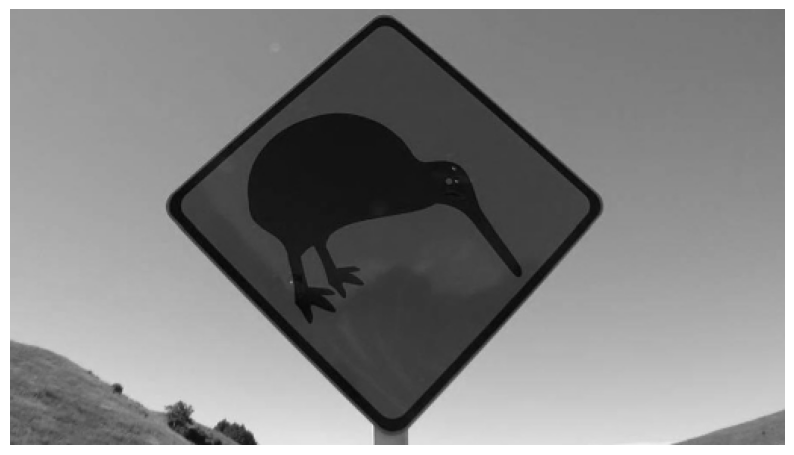

In [17]:
from detectron2.utils.visualizer import ColorMode

files = Glob('train/myData202')

for _ in range(30):
  im = cv2.imread(str(choose(files)))
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                 scale=0.5,
                 metadata=MetadataCatalog.get("dataset_train"),
                 instance_mode=ColorMode.IMAGE_BW
  # remove the colors of unsegmented pixels.
  # This option is only available for segementation models
                )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show(out.get_image())

`Visualizer` is Detectron2's way of plotting object instances. Given that the predictions (present in the `outputs` variable) are a mere dictionary of tensors, `Visualuzer` converts them into pixel information and draws them on an image. Let's see what each input means:

* i.`im`: The image we want to visualize.
* ii. `scale`: The size of the image when plotted. Here, we are askinig it to shrink the image down to 50%.
* iii.`metadata`: We need class-level information for the dataset, mainly the index-to-class mapping so that when we send the raw tensors as input to be plotted, the class will decode them into actual human-readable classes.
* iv.`instance_mode`: We are asking the model to only highlight the segmented pixels

##5.Finally,once the class is created(in our example, it is `v`), we can ask it to draw instance predictions coming from the model and show the image.

The preceding code gives the following output. Notice that we are able to identify the pixels corresponding to the elephants fairly accurately:

In [21]:
from detectron2.data import MetadataCatalog

metadata = MetadataCatalog.get("dataset_train")
print(metadata)


Metadata(name='dataset_train')


✅ Found 5094 images.
📸 Using image: train/myData202/3aabc897af0d1577.jpg
✅ Loaded image shape: (683, 1024, 3)
⚠️ No predictions for image: train/myData202/3aabc897af0d1577.jpg
📸 Using image: train/myData202/d3be2b44c3b47c7e.jpg
✅ Loaded image shape: (740, 1024, 3)
⚠️ No predictions for image: train/myData202/d3be2b44c3b47c7e.jpg
📸 Using image: train/myData202/a6086af6518d931e.jpg
✅ Loaded image shape: (690, 1024, 3)
⚠️ No predictions for image: train/myData202/a6086af6518d931e.jpg
📸 Using image: train/myData202/cdd93924d0f12ae3.jpg
✅ Loaded image shape: (768, 1024, 3)
⚠️ No predictions for image: train/myData202/cdd93924d0f12ae3.jpg
📸 Using image: train/myData202/669ee04fc00f2d9e.jpg
✅ Loaded image shape: (768, 865, 3)
⚠️ No predictions for image: train/myData202/669ee04fc00f2d9e.jpg
📸 Using image: train/myData202/38b6ff2203830e13.jpg
✅ Loaded image shape: (707, 1024, 3)
⚠️ No predictions for image: train/myData202/38b6ff2203830e13.jpg
📸 Using image: train/myData202/f5ae3eb4673b8923.jp

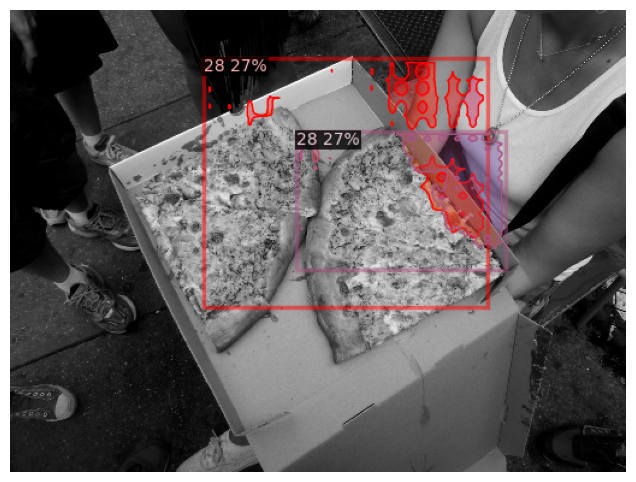

📸 Using image: train/myData202/00eac367b23ef0ec.jpg
✅ Loaded image shape: (682, 1024, 3)
⚠️ No predictions for image: train/myData202/00eac367b23ef0ec.jpg
📸 Using image: train/myData202/9ac558580b3ed06b.jpg
✅ Loaded image shape: (768, 1024, 3)
⚠️ No predictions for image: train/myData202/9ac558580b3ed06b.jpg
📸 Using image: train/myData202/22e798fc919f12b8.jpg
✅ Loaded image shape: (683, 1024, 3)
⚠️ No predictions for image: train/myData202/22e798fc919f12b8.jpg
📸 Using image: train/myData202/d23062feec698392.jpg
✅ Loaded image shape: (768, 1024, 3)
⚠️ No predictions for image: train/myData202/d23062feec698392.jpg
📸 Using image: train/myData202/1770fad3b37cb372.jpg
✅ Loaded image shape: (1024, 847, 3)
⚠️ No predictions for image: train/myData202/1770fad3b37cb372.jpg
📸 Using image: train/myData202/8d95e42db9b71ad9.jpg
✅ Loaded image shape: (426, 1024, 3)
⚠️ No predictions for image: train/myData202/8d95e42db9b71ad9.jpg
📸 Using image: train/myData202/7555e10a6b94c107.jpg
✅ Loaded image sha

In [20]:
import cv2
import random
import matplotlib.pyplot as plt
from glob import glob
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

# Ensure predictor is defined somewhere before running this script

# Get all image paths from the dataset directory
files = glob('train/myData202/*')  # Ensure correct path

# Ensure images were found
if not files:
    print("⚠️ No images found in 'train/myData202/'! Check the directory path.")
else:
    print(f"✅ Found {len(files)} images.")

# Choose 30 random images for visualization
for _ in range(30):
    img_path = random.choice(files)
    print(f"📸 Using image: {img_path}")

    # Read the image
    im = cv2.imread(img_path)

    # Ensure the image was loaded correctly
    if im is None:
        print(f"❌ Failed to load image: {img_path}")
        continue
    print(f"✅ Loaded image shape: {im.shape}")

    # Run the model prediction
    outputs = predictor(im)

    # Ensure the model produced some output
    if "instances" not in outputs or len(outputs["instances"]) == 0:
        print(f"⚠️ No predictions for image: {img_path}")
        continue
    print(f"✅ Detected {len(outputs['instances'])} objects.")

    # Visualize results
    v = Visualizer(
        im[:, :, ::-1],  # Convert BGR to RGB
        scale=0.5,
        metadata=MetadataCatalog.get("dataset_train"),
        instance_mode=ColorMode.IMAGE_BW,  # Show unsegmented pixels in black & white
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display image
    plt.figure(figsize=(8, 6))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()
